# Exercises

## Exercise 1 - simulating place cells
---
Use the code we build to simulate place cells in the lesson.

A - Explore what happens when you change the binning in the definition of the firing rate maps (`space_bins`). Make it coarser or broader. 


B - In the spike train simulations, we add some "baseline" noise, not place-related to the firing. Which variable determines the noise level? Try to experiment with that variable and see what happens to the firing rate maps. What is the best approach to firing rate maps when the noise is high.


C - We could use other approaches to firing rate maps: for example make the binning very small (down to 1 cm, which is the resolution of our "video" data, and then applying a gaussian smoother. Scipy has a Gaussian smoother at `scipy.stats.gaussian_kde`. Read the documentation for that function and apply it to the data to define the smoothed firing rate maps. Again, change the noise levels and see how the smoother changes. 

D - When analyzing place fields, two important quantities are the place field center and the place field width. The place field center may be defined in many ways, but one is to compute the "center of mass" of the spikes according to the equation 

$$ c_{pf} = \frac{1}{N_{spikes}} \sum_{i} L_i $$ 

where the sum on $i$ runs on all spikes emitted by a cell and $L_i$ is the location at which the i-th spike was emitted. Calculate this for each cell. Compare with the "true" place field centers from the simulations (which variables are we talking about?) 


#### Code taken from lesson

In [206]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from tqdm import tqdm
import seaborn as sns
import pickle
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})


In [207]:
track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

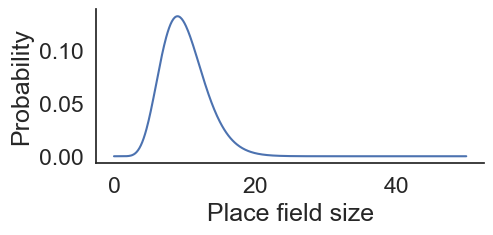

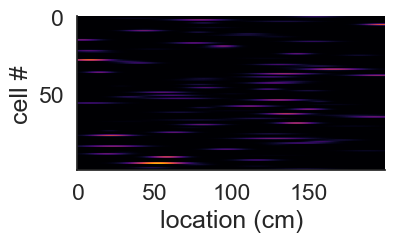

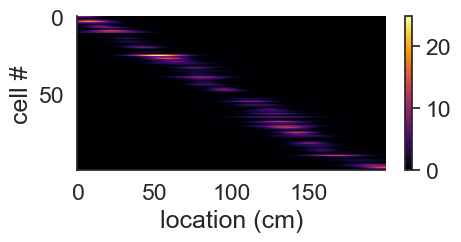

In [208]:
x = np.arange(0., 50., 0.1) # we use a grid with step 0.1
g = scipy.stats.gamma.pdf(x, 10)
plt.figure(figsize=(5,2))
plt.plot(x, g)
plt.xlabel('Place field size')
plt.ylabel('Probability')
plt.show()

bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

plt.figure(figsize=(5,2))
plt.imshow(true_firing_rate_maps, cmap='inferno')
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.show()

plt.figure(figsize=(5,2))
ix = np.argsort(pf_centers)
plt.imshow(true_firing_rate_maps[ix,:], cmap='inferno')
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()
plt.show()


In [209]:
n_runs = 20 
av_running_speed = 10 # the average running speed (in cm/s)
fps = 30 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps

Text(0, 0.5, 'position on track (cm)')

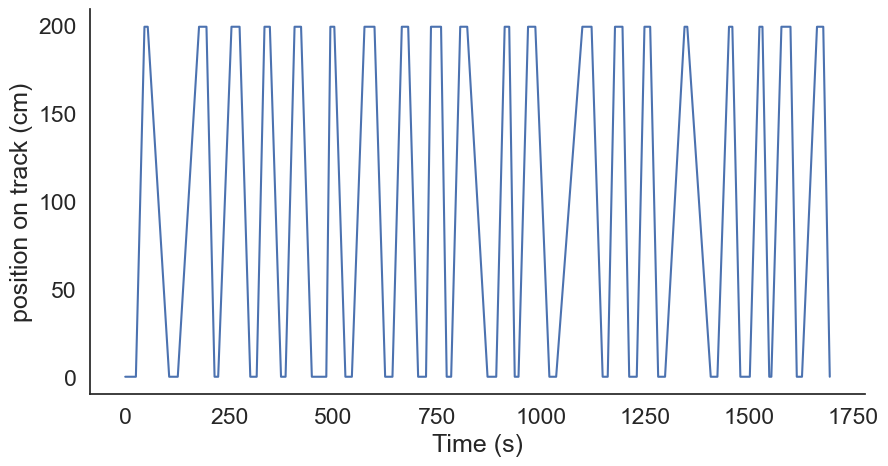

In [210]:
plt.figure(figsize=(10,5))
plt.plot(t, x)
plt.xlabel('Time (s)')
plt.ylabel('position on track (cm)')

In [211]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


In [212]:
def plot_unit(i):
    plt.figure(figsize=(10,5))
    plt.plot(t, x)
    plt.plot(spikes[i], np.interp(spikes[i], t, x), 'r.')
    plt.xlabel('Time (s)')
    plt.ylabel('position on track (cm)')
    
interact(plot_unit, i = widgets.IntSlider(min=0, max=(n_cells-1), value=0))

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_unit(i)>

In [213]:
spike_positions = [np.interp(s, t, x) for s in spikes]

#### Code for Exercise 1

In [214]:
# 1.A
def rate_map(binsize = 5., spike_positions = spike_positions):
    space_bins = np.arange(0., 200., binsize)
    
    # we compute histograms for eaxh cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    
    # put them together into a matrix of floating point numbers (for plotting)
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)
    
    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps
    
    firing_rate_maps = spikes_hist / (occupancy + 10**-15)
    
    return firing_rate_maps

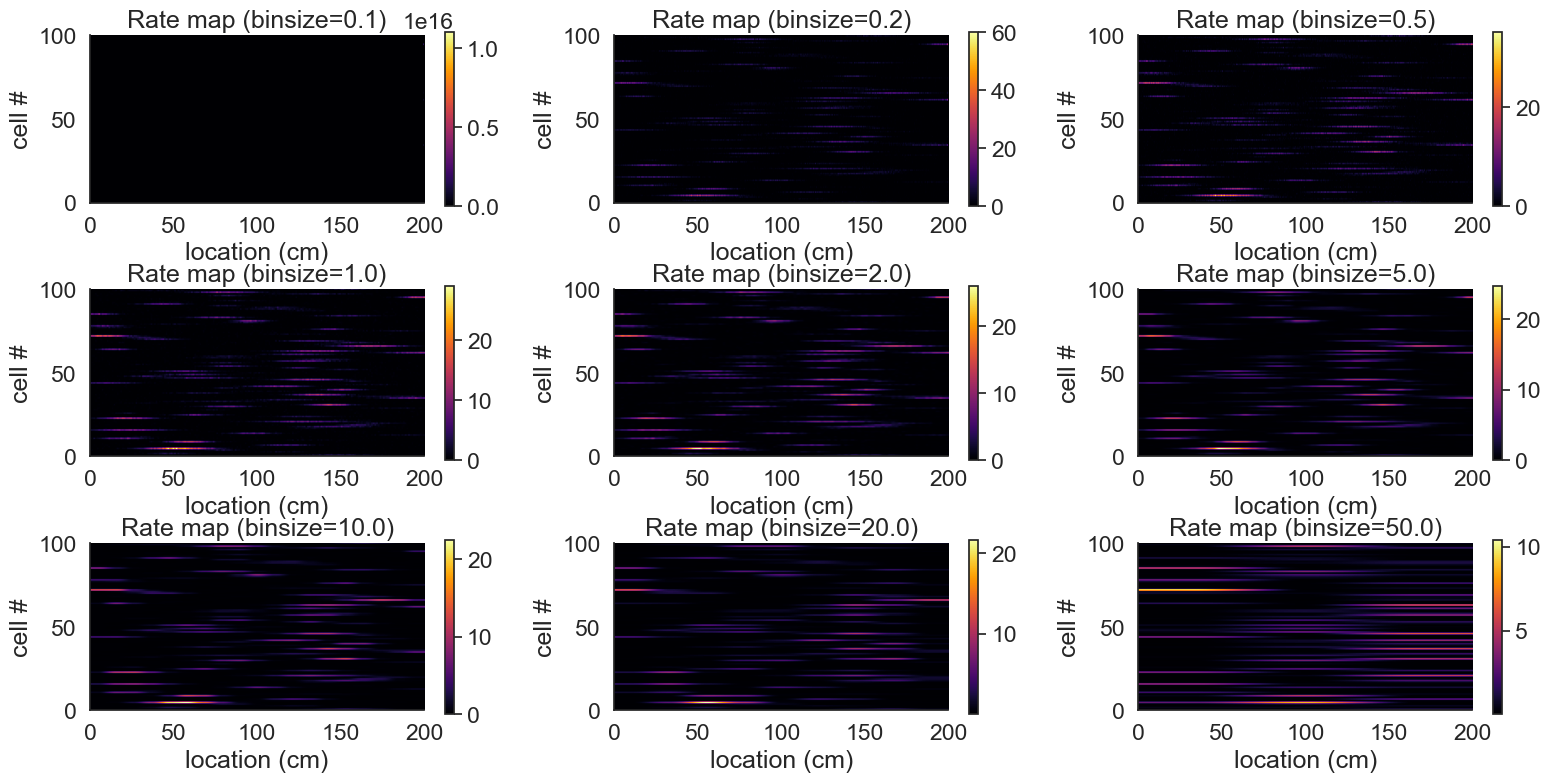

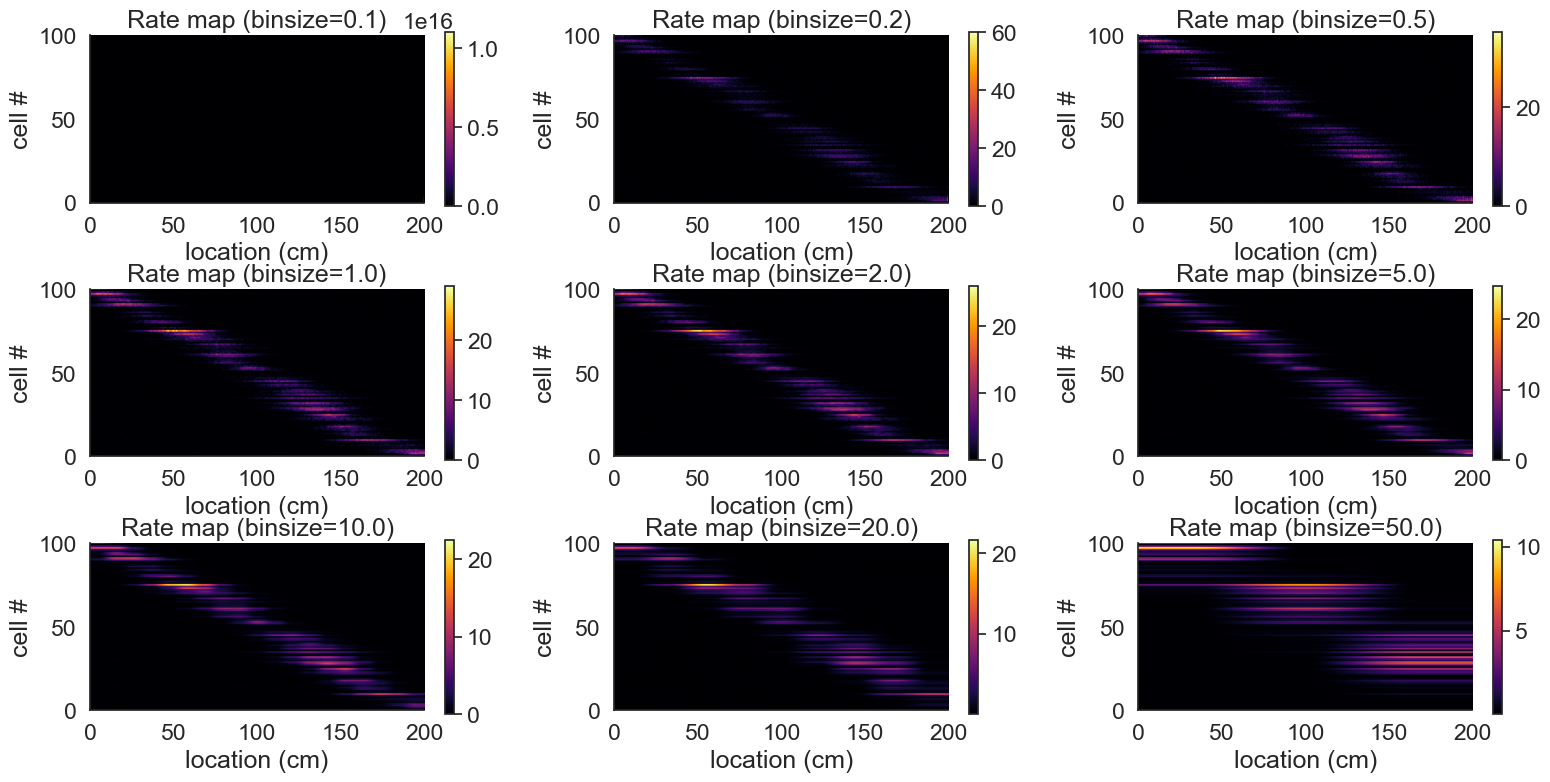

In [215]:
# default binsize is 5
binsizes = [0.1, 0.2, 0.5, 1., 2., 5., 10., 20., 50.]

# plot unsorted rate maps
plt.figure(figsize = (16,8))
for i, binsize in enumerate(binsizes):
    plt.subplot(3, 3, i + 1)
    plt.imshow(rate_map(binsize), cmap='inferno', extent = [0, 200, 0, n_cells])
    plt.title(f'Rate map (binsize={binsize})')
    plt.colorbar()
    plt.xlabel('location (cm)')
    plt.ylabel('cell #')
    
plt.tight_layout()
plt.show()

# plot sorted rate maps
ix = np.argsort(pf_centers)
plt.figure(figsize = (16,8))
for i, binsize in enumerate(binsizes):
    plt.subplot(3, 3, i + 1)
    plt.imshow(rate_map(binsize)[ix,:], cmap='inferno', extent = [0, 200, 0, n_cells])
    plt.title(f'Rate map (binsize={binsize})')
    plt.colorbar()
    plt.xlabel('location (cm)')
    plt.ylabel('cell #')

plt.tight_layout()
plt.show()

In [216]:
def plot_map(logbinsize):
    binsize = 10**logbinsize
    ix = np.argsort(pf_centers)
    plt.figure(figsize = (16,8))
    plt.imshow(rate_map(binsize)[ix,:], cmap='inferno', extent = [0, 200, 0, n_cells])
    plt.title(f'Rate map (binsize={binsize})')
    plt.colorbar()
    plt.xlabel('location (cm)')
    plt.ylabel('cell #')

interact(plot_map, logbinsize = widgets.FloatSlider(min=-2, max= 2, step = .1, value=np.log10(5)))

interactive(children=(FloatSlider(value=0.6989700043360189, description='logbinsize', max=2.0, min=-2.0), Outp…

<function __main__.plot_map(logbinsize)>

The binsize smears out the peaks/bands if it gets too large, and if it is too low the number of spikes in each bin is too low to show up in the graph. And also there appear gaps inside the bands because the spikes are not distributed uniformly.

In [219]:
# 1.B

# generate data for each noise level, output is a list with dimensions [nr_of_noises, n_cells, nr_of_spikes]
noise_frs = [0.05,0.1,0.2,0.5,1.,2.,5.,10.,20.]
var_noise_spikes = []
var_noise_spike_positions = []
for j, noise_firing_rate in enumerate(noise_frs):
    sampling_rate = 10000.
    t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
    x_sampling = np.floor(np.interp(t_sampling, t, x))
    spikes = []
    
    for i in tqdm(range(n_cells)):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)
        
    spike_positions = [np.interp(s, t, x) for s in spikes]
    
    var_noise_spikes.append(spikes)
    var_noise_spike_positions.append(spike_positions)

100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


In [220]:
def plot_noisy_unit(noise_level, i):
    spikes = var_noise_spikes[noise_level]
    plt.figure(figsize=(10,5))
    plt.plot(t, x)
    plt.plot(spikes[i], np.interp(spikes[i], t, x), 'r.')
    plt.xlabel('Time (s)')
    plt.ylabel('position on track (cm)')
    plt.title(f'Noise level = {noise_frs[noise_level]}')
    
interact(plot_noisy_unit, 
         noise_level = widgets.IntSlider(min=0, max=(len(noise_frs)-1), value=4),
         i = widgets.IntSlider(min=0, max=(n_cells-1), value=0))

interactive(children=(IntSlider(value=4, description='noise_level', max=8), IntSlider(value=0, description='i'…

<function __main__.plot_noisy_unit(noise_level, i)>

In the above interactive plot you can vary the noise level and the cell number to see what the distribution is of the spikes in space for each level of noise.

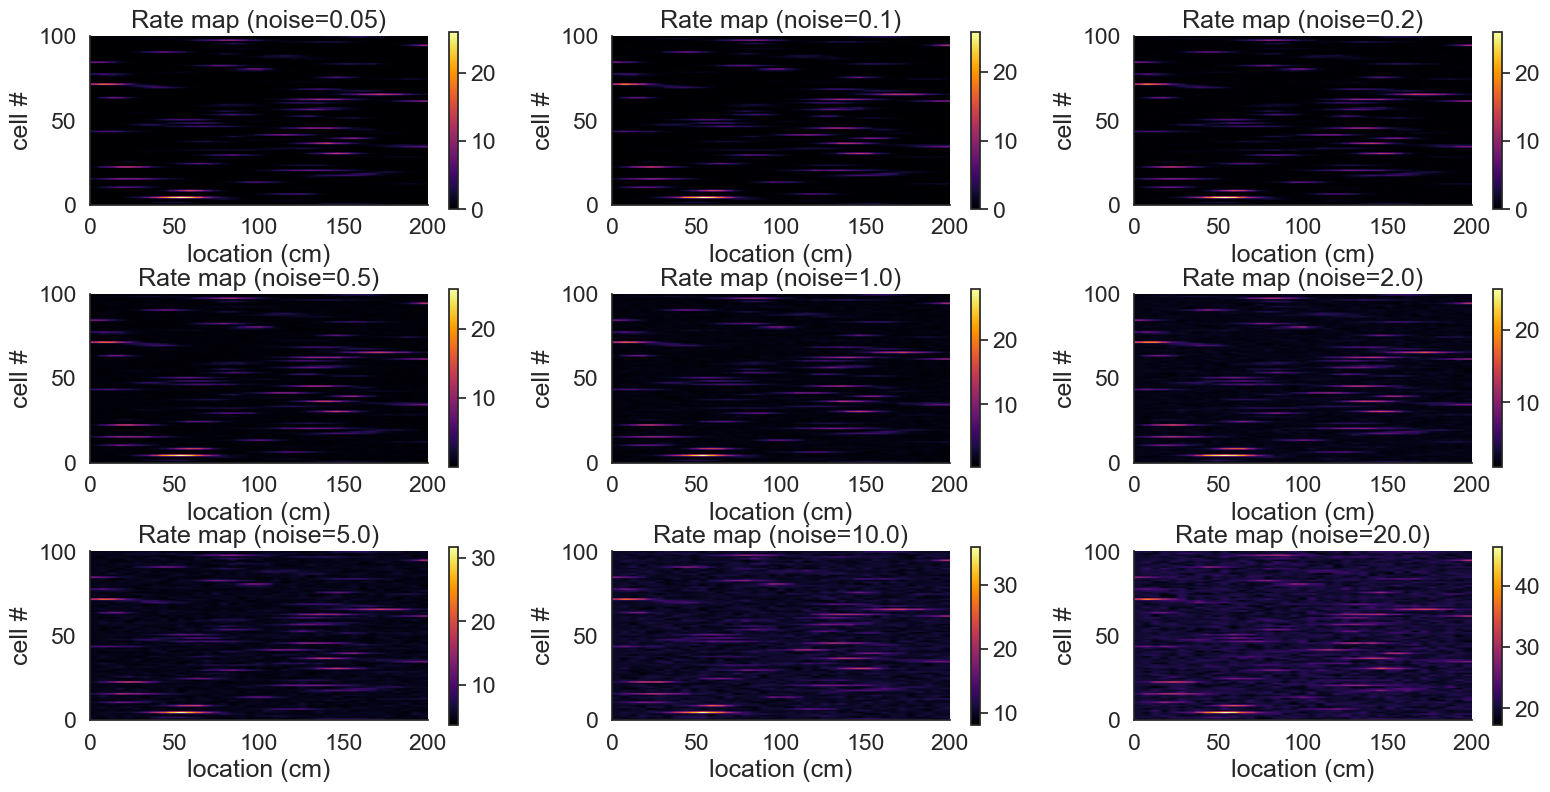

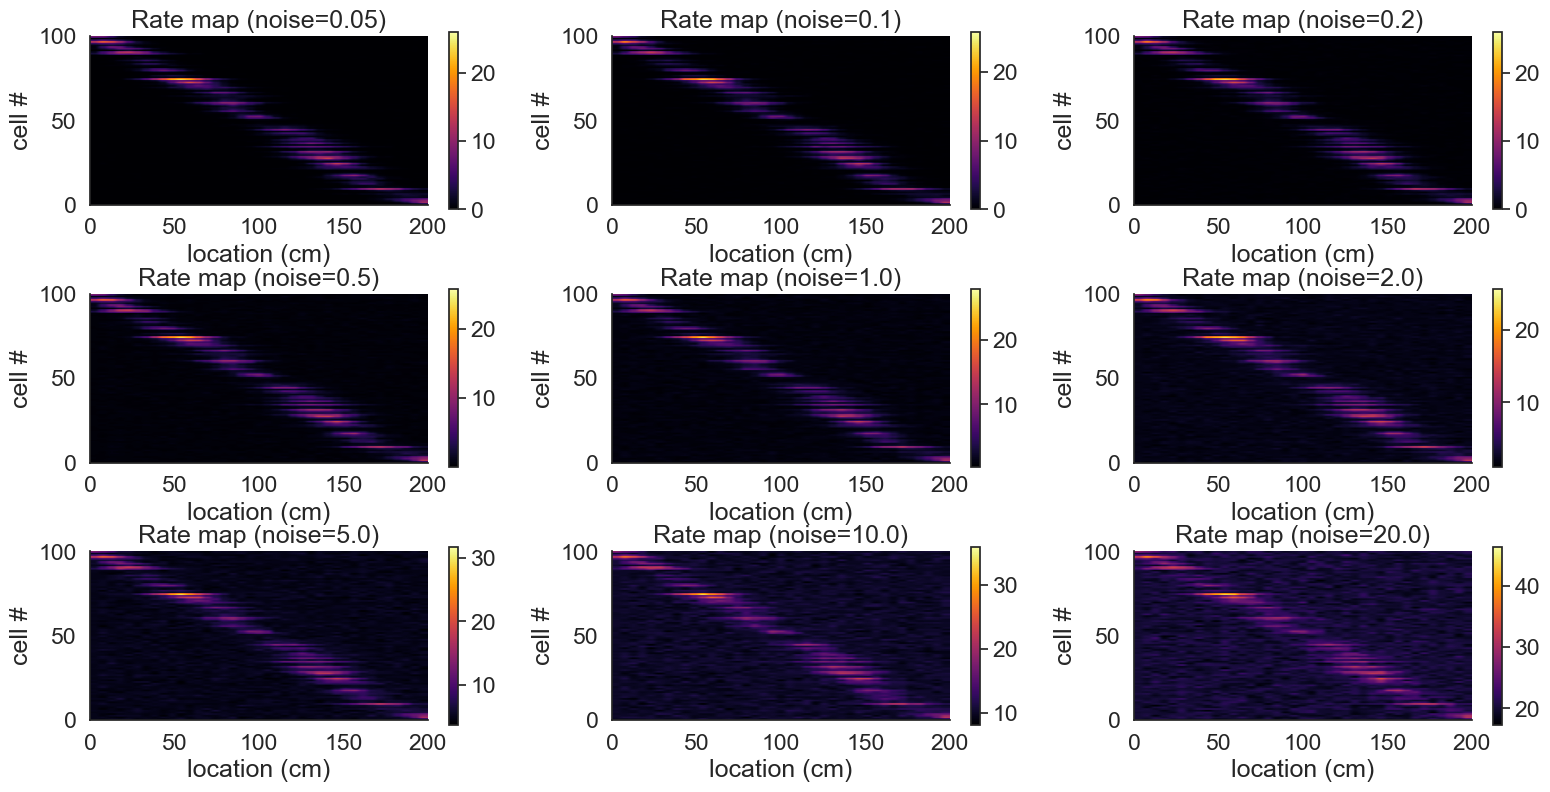

In [221]:
# plot unsorted rate maps
plt.figure(figsize = (16,8))
for i, nfr in enumerate(noise_frs):
    spikes = var_noise_spikes[i]
    plt.subplot(3, 3, i + 1)
    plt.imshow(rate_map(spike_positions = var_noise_spike_positions[i]), cmap='inferno', extent = [0, 200, 0, n_cells])
    plt.title(f'Rate map (noise={nfr})')
    plt.colorbar()
    plt.xlabel('location (cm)')
    plt.ylabel('cell #')
    
plt.tight_layout()
plt.show()

# plot sorted rate maps
ix = np.argsort(pf_centers)
plt.figure(figsize = (16,8))
for i, nfr in enumerate(noise_frs):
    spikes = var_noise_spikes[i]
    plt.subplot(3, 3, i + 1)
    plt.imshow(rate_map(spike_positions = var_noise_spike_positions[i])[ix,:], cmap='inferno', extent = [0, 200, 0, n_cells])
    plt.title(f'Rate map (noise={nfr})')
    plt.colorbar()
    plt.xlabel('location (cm)')
    plt.ylabel('cell #')

plt.tight_layout()
plt.show()

In [222]:
def plot_map_noise(nfr_index):
    plt.figure(figsize = (16,8))
    spikes = var_noise_spikes[nfr_index]
    ix = np.argsort(pf_centers)
    plt.imshow(rate_map(spike_positions = var_noise_spike_positions[nfr_index])[ix,:], cmap='inferno', extent = [0, 200, 0, n_cells])
    plt.title(f'Rate map (noise={noise_frs[nfr_index]})')
    plt.colorbar()
    plt.xlabel('location (cm)')
    plt.ylabel('cell #')

interact(plot_map_noise, nfr_index = widgets.IntSlider(min=0, max = (len(noise_frs)-1), value=0))

interactive(children=(IntSlider(value=0, description='nfr_index', max=8), Output()), _dom_classes=('widget-int…

<function __main__.plot_map_noise(nfr_index)>

You can still quite clearly see the peaks at high noise levels, however for the unsorted graphs it does become harder to spot the bands with lower peaks. 

In [223]:
# 1.C
# binsize = 1 (cm)
binsize = 1

def plot_map_noise(nfr_index):
    plt.figure(figsize = (16,8))
    spikes = var_noise_spikes[nfr_index]
    ix = np.argsort(pf_centers)
    
    rate_map_data = rate_map(binsize=binsize, spike_positions=var_noise_spike_positions[nfr_index])[ix, :]
    rate_map_data = np.array(rate_map_data)
    kde = scipy.stats.gaussian_kde(rate_map_data.ravel())
    density = kde(rate_map_data.ravel()).reshape(rate_map_data.shape)
    density = np.max(density) - density
    
    plt.imshow(density, cmap='inferno', extent=[0, 200, 0, n_cells])
    plt.title(f'Rate map (noise={noise_frs[nfr_index]})')
    plt.colorbar()
    plt.xlabel('location (cm)')
    plt.ylabel('cell #')

interact(plot_map_noise, nfr_index = widgets.IntSlider(min=0, max = (len(noise_frs)-1), value=1))

interactive(children=(IntSlider(value=1, description='nfr_index', max=8), Output()), _dom_classes=('widget-int…

<function __main__.plot_map_noise(nfr_index)>

This approach does seem to help improve the visibility of each entire band, though it does seem to remove the visibility of the peaks entirely as the bands seem to have an entirely uniform rate. Even at higher noise levels now, it is easier to spot the bands than before. 

In [224]:
# 1.D
# calculate the mean and standard deviations of the spike positions for each cell
mean_spike_positions = np.zeros((len(noise_frs), n_cells))
std_spike_positions = np.zeros((len(noise_frs), n_cells))
for i, nfr in enumerate(noise_frs):
    for j in range(n_cells):
        mean_spike_positions[i,j] = np.mean(var_noise_spike_positions[i][j])
        std_spike_positions[i,j] = np.std(var_noise_spike_positions[i][j])

def plot_spike_peakwidth(i):
    plt.figure(figsize = (10,6))
    plt.plot(mean_spike_positions[i], label = 'mean of spike positions')
    plt.fill_between(np.arange(0,n_cells), 
                     mean_spike_positions[i] - std_spike_positions[i], 
                     mean_spike_positions[i] + std_spike_positions[i], 
                     alpha = 0.5, label = 'std of spike positions')
    plt.plot(pf_centers, label = 'true spike positions')
    plt.title(f'Unsorted mean spike positions (noise = {noise_frs[i]})')
    plt.legend(fontsize = "xx-small")
    plt.xlabel("cell #")
    plt.ylabel('location (cm)')
    plt.show()

interact(plot_spike_peakwidth, i = widgets.IntSlider(min=0, max = (len(noise_frs)-1), value=1))

interactive(children=(IntSlider(value=1, description='i', max=8), Output()), _dom_classes=('widget-interact',)…

<function __main__.plot_spike_peakwidth(i)>

In [225]:
def plot_error(i):
    plt.figure(figsize = (10,6))
    plt.plot(mean_spike_positions[i]-pf_centers, label = 'error of mean positions')
    plt.fill_between(np.arange(0,n_cells), 
                     - std_spike_positions[i], 
                     std_spike_positions[i], 
                     alpha = 0.5, label = 'std of spike positions')
    plt.title(f'Unsorted error mean spike positions with true centers (noise = {noise_frs[i]})')
    plt.legend(fontsize = "xx-small")
    plt.xlabel("cell #")
    plt.ylabel('location (cm)')
    plt.show()

interact(plot_error, i = widgets.IntSlider(min=0, max = (len(noise_frs)-1), value=1))

interactive(children=(IntSlider(value=1, description='i', max=8), Output()), _dom_classes=('widget-interact',)…

<function __main__.plot_error(i)>

At low noise levels the error of the mean spike positions with the true spike positions is smaller than the standard deviation of the spike positions. However, at high noise levels the std and the error both grow to the limit of the track length and the error at times is bigger than the standard deviation.

## Exercise 2 - mutual information
---
A - Implement the mutual information formula discussed in the lesson, and apply it to the place cell data we simulated.

B - Adapt the simulation so that you can systematically vary 1) Peak firing rate, 2) place cell size 3) baseline noise. 
Study how mutual information vary with these parameters. Use both definition of mutual information above, and discuss the differences between them. Make some plots to show how the dependency goes.

In [230]:
# 2.A
# I = sum over space of ( fr(x) log2 (fr(x) + eps / avg_fr) * occupation)
# in practice this turns into a sum over the bins, and fr(x) is the firing rate of that bin.
def rate_map_with_occupancy(binsize = 5., spike_positions = spike_positions):
    space_bins = np.arange(0., 200., binsize)
    
    # we compute histograms for eaxh cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    
    # put them together into a matrix of floating point numbers (for plotting)
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)
    
    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps
    
    firing_rate_maps = spikes_hist / (occupancy + 10**-15)
    
    return firing_rate_maps, occupancy


def information(spike_positions = spike_positions, binsize = 5, eps = 10**-15):
    I = np.zeros(n_cells)
    rate_map_data, occupancy =  rate_map_with_occupancy(binsize=binsize, spike_positions=spike_positions)
    rate_map_data = np.array(rate_map_data)[ix, :]
    occupancy = np.array(occupancy)
    avg_fr = np.mean(rate_map_data, axis = 1)
    I = np.sum(rate_map_data * occupancy * np.log2((rate_map_data + eps)/ avg_fr.reshape(avg_fr.shape[0], 1)), axis = 1)
    Is = I/avg_fr
    return I, Is

I = np.zeros((len(noise_frs), n_cells))
Is = np.zeros((len(noise_frs), n_cells))
for i in range(len(noise_frs)):
    I[i], Is[i] = information(spike_positions = var_noise_spike_positions[i])

def plot_information(i):
    plt.figure(figsize = (10,6))
    plt.plot(I[i], label = 'I')
    plt.plot(Is[i], label = '$I_s$')
    plt.legend()
    plt.xlabel("cell #")
    plt.ylabel('information')
    plt.title(f'Information of place cell data (noise = {noise_frs[i]})')
    plt.show()

interact(plot_information, i = widgets.IntSlider(min=0, max = (len(noise_frs)-1), value=1))

interactive(children=(IntSlider(value=1, description='i', max=8), Output()), _dom_classes=('widget-interact',)…

<function __main__.plot_information(i)>

At low noise levels the information (I) and information averaged by the firing rate (Is, 2nd definition) both look very similar, with a similar range. But as the noise level increases, the Is goes down to a range where it looks basically constant compared to I. The overal range of the information decreases as well though, from about max 20000 to max 7000.

In [231]:
# 2.B
# First generate the data for each set of variables.
# Depending on the number of different variables this can take quite a while, as there are 3 different variables.
# 3 different values for each variable already results in 27 different datasets.

noise_frs = [0.1, 1.0, 10]
cell_sizes = [5, 10, 20]
peak_frs = [1, 5, 10]

# Generate data for the range of variables
# Store in a list of dimensions [# of peak_frs, # of cell_sizes, # of noises, n_cells, # of spikes]
# It might be more efficient to compute the rate_maps and then store those in a numpy array, but I prefer to just generate this raw data once.
# It can take a while however! (~40s per variable set -> (with 27 variable sets) -> ~ 20 mins)
def gen_data(peak_frs, cell_sizes, noise_frs, track_length = 200., n_cells = 100, sampling_rate = 10000.):
    var_peak_spikes = []
    var_peak_spike_positions = []
    for m, average_firing_rate in enumerate(peak_frs):
        var_size_spikes = []
        var_size_spike_positions = []
        for k, cell_size in enumerate(cell_sizes):
            pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
            pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
            pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

            bins = np.arange(0., 200.)
            true_firing_rate_maps = np.zeros((n_cells, len(bins)))
            for i in range(n_cells):
                true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))
            
            var_noise_spikes = []
            var_noise_spike_positions = []
            for j, noise_firing_rate in enumerate(noise_frs):
                t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
                x_sampling = np.floor(np.interp(t_sampling, t, x))
                spikes = []
                
                for i in tqdm(range(n_cells), file=sys.stdout):
                    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
                    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
                    sp = np.argwhere(spikes_loc)
                    t_sp = t_sampling[sp]
                    spikes.append(t_sp)
                    
                spike_positions = [np.interp(s, t, x) for s in spikes]
                
                var_noise_spikes.append(spikes)
                var_noise_spike_positions.append(spike_positions)
                print(f'noise {j} done')
            var_size_spikes.append(var_noise_spikes)
            var_size_spike_positions.append(var_noise_spike_positions)
            print(f'cell_size {k} done')
        var_peak_spikes.append(var_size_spikes)
        var_peak_spike_positions.append(var_size_spike_positions)
        print(f'peak_fr {m} done')
    return var_peak_spikes, var_peak_spike_positions

In [26]:
# this cell generates the actual data, i recommend only running this once.
# you could also remove/edit a couple variables or reduce the number of cells.
noise_frs = [0.1, 1.0, 10]
cell_sizes = [5, 10, 20]
peak_frs = [1, 5, 10]

raw_data_spikes, raw_data_spike_positions = gen_data(noise_frs, cell_sizes, peak_frs)

100%|██████████| 100/100 [00:38<00:00,  2.57it/s]
noise 0 done
100%|██████████| 100/100 [00:38<00:00,  2.57it/s]
noise 1 done
100%|██████████| 100/100 [00:38<00:00,  2.57it/s]
noise 2 done
cell_size 0 done
100%|██████████| 100/100 [00:39<00:00,  2.55it/s]
noise 0 done
100%|██████████| 100/100 [00:39<00:00,  2.56it/s]
noise 1 done
100%|██████████| 100/100 [00:38<00:00,  2.57it/s]
noise 2 done
cell_size 1 done
100%|██████████| 100/100 [00:38<00:00,  2.57it/s]
noise 0 done
100%|██████████| 100/100 [00:39<00:00,  2.56it/s]
noise 1 done
100%|██████████| 100/100 [00:38<00:00,  2.57it/s]
noise 2 done
cell_size 2 done
peak_fr 0 done
100%|██████████| 100/100 [00:39<00:00,  2.56it/s]
noise 0 done
100%|██████████| 100/100 [00:39<00:00,  2.56it/s]
noise 1 done
100%|██████████| 100/100 [00:38<00:00,  2.57it/s]
noise 2 done
cell_size 0 done
100%|██████████| 100/100 [00:38<00:00,  2.57it/s]
noise 0 done
100%|██████████| 100/100 [00:38<00:00,  2.57it/s]
noise 1 done
100%|██████████| 100/100 [00:39<00:

In [232]:
# use generated data and make an interactive plot to allow switching between each set of variables
I = np.zeros((len(peak_frs), len(cell_sizes), len(noise_frs), n_cells))
Is = np.zeros((len(peak_frs), len(cell_sizes), len(noise_frs), n_cells))
for i in range(len(peak_frs)):
    for j in range(len(cell_sizes)):
        for k in range(len(noise_frs)):
            I[i,j,k], Is[i,j,k] = information(spike_positions = raw_data_spike_positions[i][j][k])

def plot_information2(peak_fr_index, cell_size_index, noise_fr_index):
    plt.figure(figsize = (10,6))
    I_ijk = I[peak_fr_index, cell_size_index, noise_fr_index]
    Is_ijk = Is[peak_fr_index, cell_size_index, noise_fr_index]
    plt.plot(I_ijk, label = 'I')
    plt.plot(Is_ijk, label = '$I_s$')
    plt.legend()
    plt.xlabel("cell #")
    plt.ylabel('information')
    plt.suptitle(f'Information (peak fr = {peak_frs[peak_fr_index]}, cell size = {cell_sizes[cell_size_index]}, noise = {noise_frs[noise_fr_index]})')
    plt.title(f'Ranges: $I = [{int(np.min(I_ijk))}, {int(np.max(I_ijk))}]$, $I_s = [{int(np.min(Is_ijk))}, {int(np.max(Is_ijk))}]$')
    plt.show()

interact(plot_information2, 
         peak_fr_index = widgets.IntSlider(min=0, max = (len(peak_frs)-1), value=1),
         cell_size_index = widgets.IntSlider(min=0, max = (len(cell_sizes)-1), value=1),
         noise_fr_index = widgets.IntSlider(min=0, max = (len(noise_frs)-1), value=1))

interactive(children=(IntSlider(value=1, description='peak_fr_index', max=2), IntSlider(value=1, description='…

<function __main__.plot_information2(peak_fr_index, cell_size_index, noise_fr_index)>

A peaky graph is theoretically a good one, because this will show the difference between the most and least informative cells the more clearly. 

For the lowest peak firing rate the information is quite low for both I and Is compared to the other peak firing rates. The plots just look like noise rather than a flat graph with a couple high peaks showing off high information cells. So to peakiness and the range of the information graphs increases with the peak firing rate.

For the default value of cell size 10, the graph seems to be have a lot more peaks than for a lower cell size (and sometimes also a higher cell size). The range for the default cell size is also lower than for the other 2 values. So this could partially explain why we observe less peaks (as there are simply fewer and higher peaks for the other cell sizes).


## Exercise 3 - working with real data
---
Load the data from `linear_track_data.pickle`. It contains neural recordings from a mouse running on a linear track.
- `x` contains the position of the animal
- `t` contains the corresponding times, in seconds
- `spikes` contains a list of lists. Each list contains the timestamps of the spikes emitted by a neuron.

A - Visualiaze the position a s a function of time. Plot the spike of a selected cell in space.

B - Calculate the firing rate maps for all the cells, and plot them sorted by increasing peak positon.

C - Calculate the spatial information for each cell, and plot the distribution. Plot the firing rate maps of the 5 cells with lower spatial information, and the firing rate maps of the 5 cells with higher spatial information. Comment on the differences.

In [235]:
#import data
# 3.A
with open('data/linear_track_data.pickle', 'rb') as handle:
    data = pickle.load(handle)

def extract_data(data):
    x = data['x']
    t = data['t']
    spikes = data['spikes']
    return x, t, spikes

print(len(data['x']))
print(len(data['spikes']))

37837
72


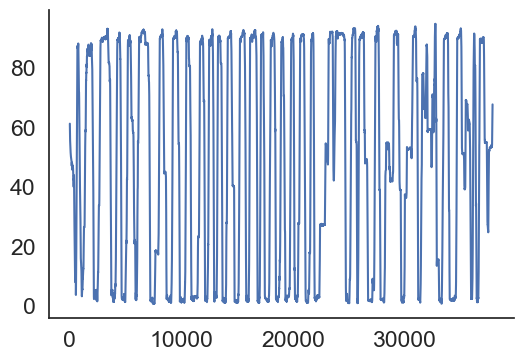

In [236]:
plt.figure(figsize = (6,4))
plt.plot(data['x'])
plt.show()

In [237]:
x, t, spikes = extract_data(data)
n_cells = len(spikes)
#use plot_unit from earlier
    
interact(plot_unit, i = widgets.IntSlider(min=0, max=(n_cells-1), value=0))

interactive(children=(IntSlider(value=0, description='i', max=71), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_unit(i)>

The cells do not seem to be very dependent on location as they fire almost independently of wherever the test subject is. And they either fire a lot or very little. The only thing that we can see is increased firing at both ends of the track for most cells.

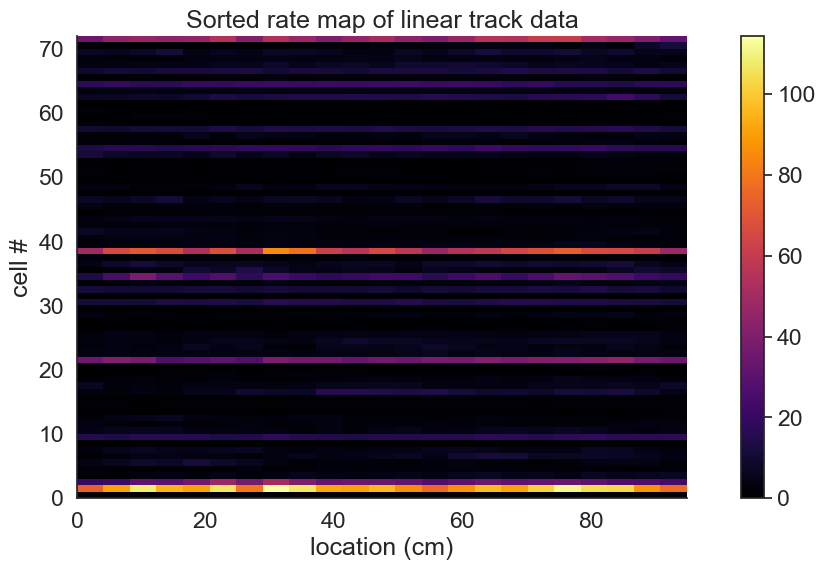

In [238]:
# 3.B
# modified rate_map function
def rate_map(spike_positions = spike_positions, binsize = 5., track_length = 200.):
    space_bins = np.arange(0., track_length, binsize)
    
    # we compute histograms for eaxh cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    
    # put them together into a matrix of floating point numbers (for plotting)
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)
    
    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps
    
    firing_rate_maps = spikes_hist / (occupancy + 10**-15)
    
    return firing_rate_maps

spike_positions = [np.interp(s, t, x) for s in spikes]

mean_spike_positions = np.zeros(n_cells)
std_spike_positions = np.zeros(n_cells)
for j in range(n_cells):
    mean_spike_positions[i] = np.mean(spike_positions[i])
    std_spike_positions[i] = np.std(spike_positions[i])

track_length = np.max(x)
ix = np.argsort(mean_spike_positions)

plt.figure(figsize=(14,6))
plt.imshow(rate_map(spike_positions = spike_positions, binsize = 4, track_length = track_length)[ix, :], 
           cmap='inferno', extent = [0, track_length, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()
plt.title('Sorted rate map of linear track data')
plt.show()

As you can also see from the space plot, the activity of the neurons does not seem to be very dependent on the location. Otherwise there would be clear peaks and widths but rather you can see a nearly constant level of activity across the whole space, varying in activity level per neuron.

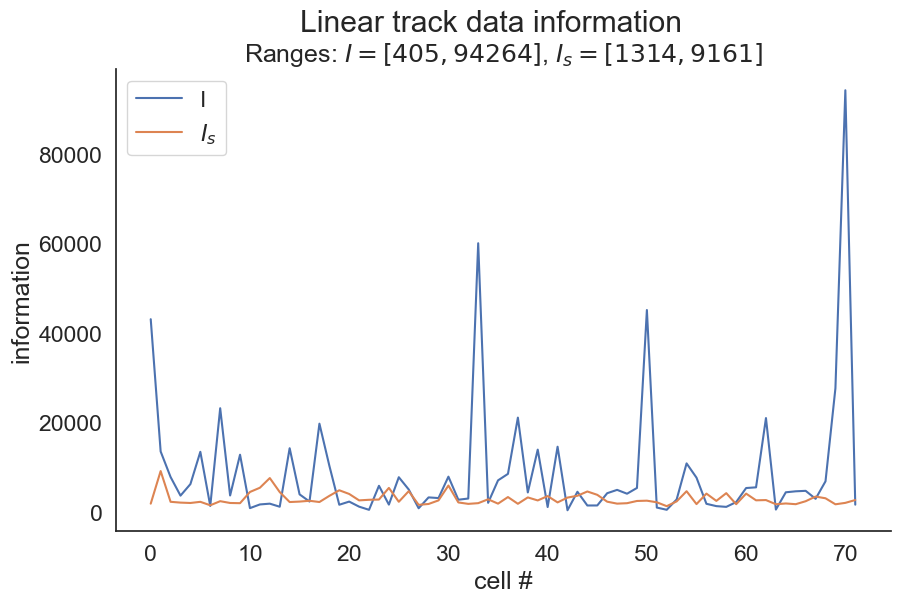

In [239]:
# 3.C
I, Is = information(spike_positions = spike_positions, binsize = 4)

plt.figure(figsize = (10,6))
plt.plot(I, label = 'I')
plt.plot(Is, label = '$I_s$')
plt.legend()
plt.xlabel("cell #")
plt.ylabel('information')
plt.suptitle(f'Linear track data information')
plt.title(f'Ranges: $I = [{int(np.min(I))}, {int(np.max(I))}]$, $I_s = [{int(np.min(Is))}, {int(np.max(Is))}]$')
plt.show()

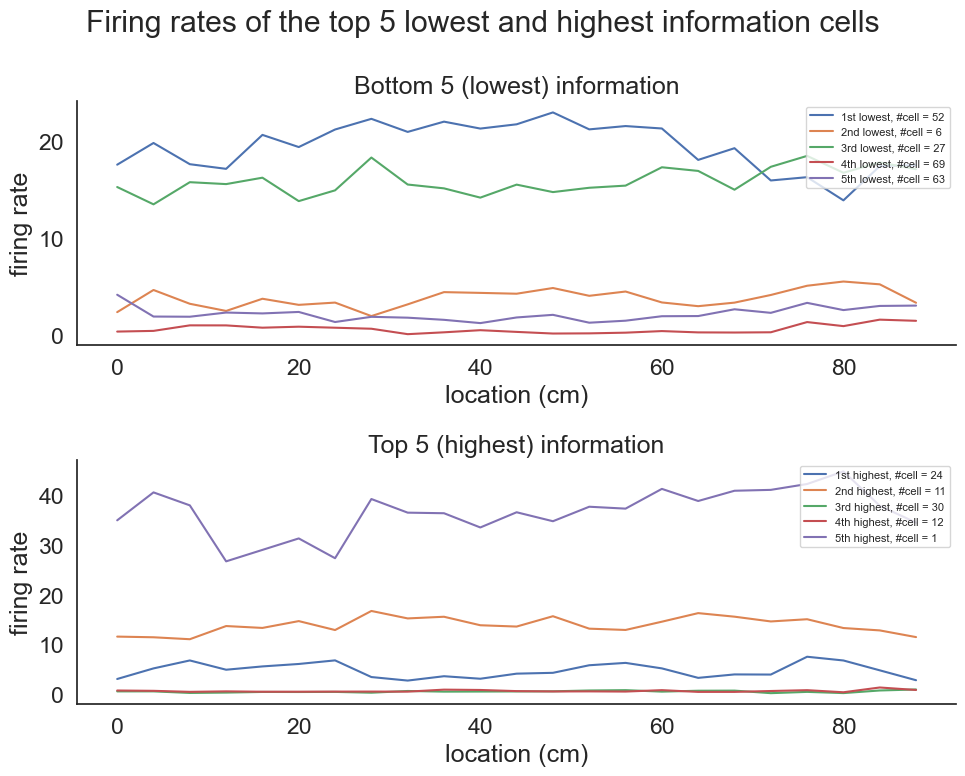

In [244]:
# Lowest 5 and highest 5 information plots (based on Is)
# I chose for Is, because it seems to make more sense to filter out the different activity levels per neuron.

sorted_indices = np.argsort(Is)
nr_of_plots = 5
binsize = 4
i_lowest = sorted_indices[:nr_of_plots]
i_highest = sorted_indices[-nr_of_plots:]

plt.figure(figsize = (10,8))
data_rate_map = rate_map(spike_positions = spike_positions, binsize = binsize, track_length = track_length)
labels = ['1st', '2nd', '3rd', '4th', '5th']

x_values = np.arange(data_rate_map.shape[1]) * binsize

plt.subplot(2,1,1)
for i in range(nr_of_plots):
    plt.plot(x_values, data_rate_map[i_lowest[i],:], label = f'{labels[i]} lowest, #cell = {i_lowest[i]}')
plt.title(f"Bottom 5 (lowest) information")
plt.legend(loc = 1, fontsize = 8)
plt.xlabel('location (cm)')
plt.ylabel('firing rate')

plt.subplot(2,1,2)
for i in range(nr_of_plots):
    plt.plot(x_values, data_rate_map[i_highest[i],:], label = f'{labels[i]} highest, #cell = {i_highest[i]}')
plt.title(f"Top 5 (highest) information")
plt.legend(loc = 1, fontsize = 8)
plt.xlabel('location (cm)')
plt.ylabel('firing rate')

plt.suptitle("Firing rates of the top 5 lowest and highest information cells")
plt.tight_layout()

plt.show()

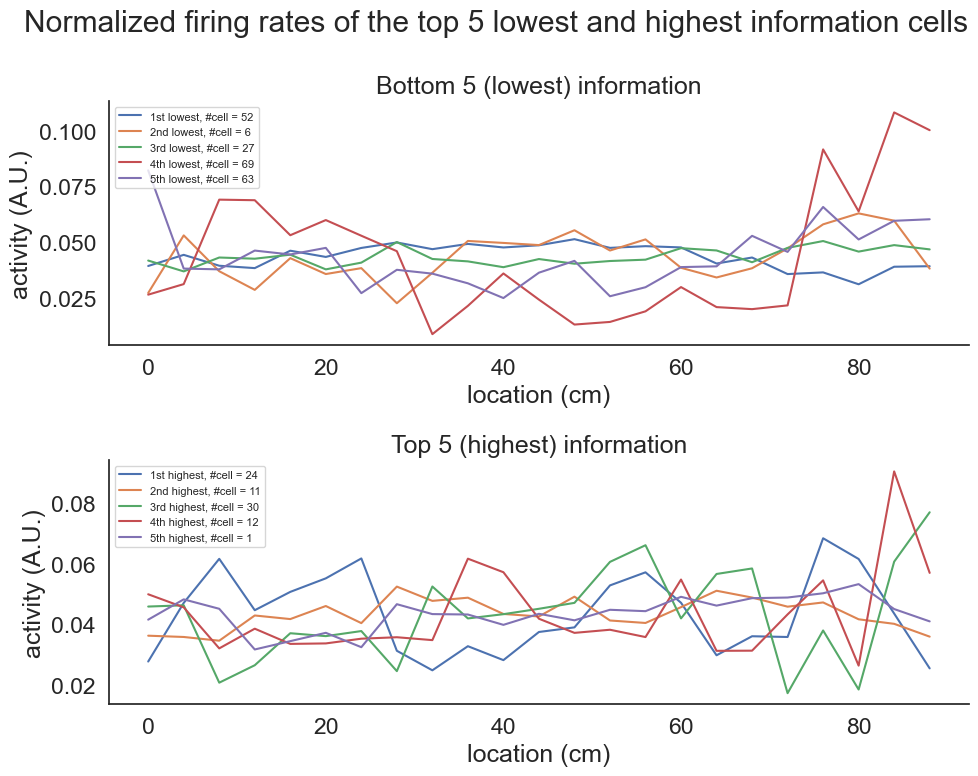

In [245]:
plt.figure(figsize = (10,8))
plt.subplot(2,1,1)
for i in range(nr_of_plots):
    y_values = data_rate_map[i_lowest[i],:]
    plt.plot(x_values, y_values/np.sum(y_values), label = f'{labels[i]} lowest, #cell = {i_lowest[i]}')
plt.title(f"Bottom 5 (lowest) information")
plt.legend(loc = 2, fontsize = 8)
plt.xlabel('location (cm)')
plt.ylabel('activity (A.U.)')

plt.subplot(2,1,2)
for i in range(nr_of_plots):
    y_values = data_rate_map[i_highest[i],:]
    plt.plot(x_values, y_values/np.sum(y_values), label = f'{labels[i]} highest, #cell = {i_highest[i]}')
plt.title(f"Top 5 (highest) information")
plt.legend(loc = 2, fontsize = 8)
plt.xlabel('location (cm)')
plt.ylabel('activity (A.U.)')

plt.suptitle("Normalized firing rates of the top 5 lowest and highest information cells")
plt.tight_layout()

plt.show()

We would expect to see a very flat graph for the least informative cells and big differences in activity across location for the most informative cells.
Most of the least informative cells indeed do have a very flat graph. However the difference between the most informative cells does not seem so clear. From the not normalized graph we can see that a couple of these cells have a higher firing rate, so maybe that has something to do with it. But this is not the case for all of the informative cells.